      Filename  Center_Index  Center_X  Center_Y  Pixel_0  Pixel_1  Pixel_2  \
0   img_10.png         20951        93       119        0        0        0   
1    img_1.png         20951        93       119        0        0        0   
2    img_0.png         22295        99       119        0        0        0   
3    img_2.png         20503        91       119        0        0        0   
4    img_3.png         20727        92       119        0        0        0   
5    img_7.png         21397        95       117        0        0        0   
6    img_6.png         21399        95       119        0        0        0   
7    img_4.png         20951        93       119        0        0        0   
8    img_5.png         19159        85       119        0        0        0   
9    img_8.png         21623        96       119        0        0        0   
10   img_9.png         20949        93       117        0        0        0   

    Pixel_3  Pixel_4  Pixel_5  ...  Pixel_50166  Pi

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


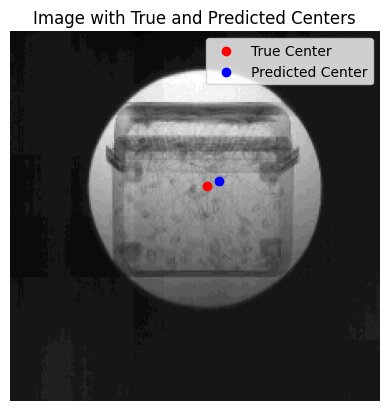

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


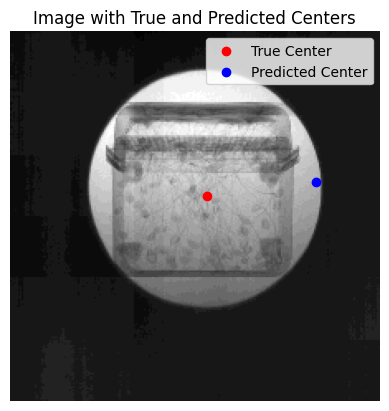

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


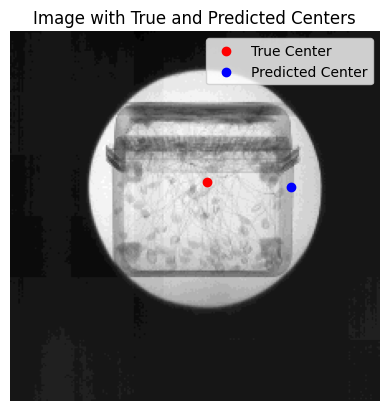

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


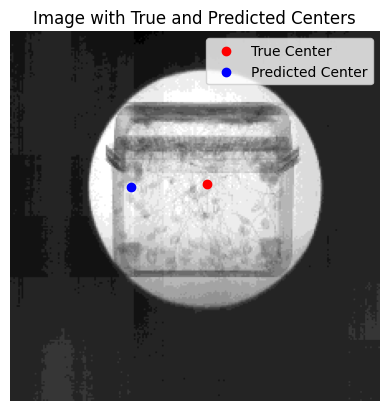

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


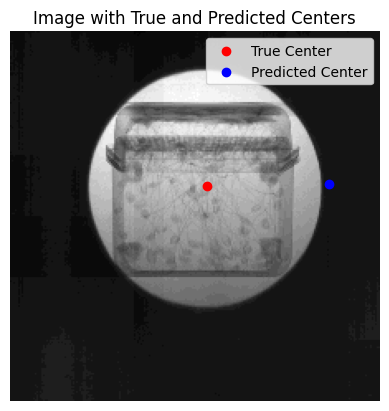

/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 

In [4]:
## cut 에 대한 최종 코드

import os
import pydicom
import cv2
from PIL import Image
import numpy as np
import pandas as pd

img_dir = "./png"

import cv2
import os
import pandas as pd
import numpy as np

def index_to_coordinates(index, shape):
    return divmod(index, shape[1])

def otsu_binarization(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def find_circle_center(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(max_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center_index = binary_image.shape[1] * cY + cX
    else:
        center_index = None
    return center_index

def process_images(img_dir):
    filenames = []
    rows = []
    
    for filename in os.listdir(img_dir):
        
        image_path = os.path.join(img_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        binary_image = otsu_binarization(image)
        center_index = find_circle_center(binary_image)
        
        # 2차원 좌표로 변환
        center_coordinates = index_to_coordinates(center_index, (224, 224))
        
        # 1차원 배열로 변환
        one_dimensional_image = binary_image.flatten()
        
        # 각 픽셀 값을 개별 행으로 추가
        row = [filename, center_index, center_coordinates[0], center_coordinates[1]] + one_dimensional_image.tolist()
        rows.append(row)
        filenames.append(filename)

    # 컬럼 이름 정의
    columns = ['Filename', 'Center_Index', 'Center_X', 'Center_Y'] + [f'Pixel_{i}' for i in range(50176)]

    # 데이터프레임 생성
    df = pd.DataFrame(rows, columns=columns)
    
    return df

result_df = process_images(img_dir)
print(result_df)


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 특징과 타겟 분리
X = result_df.drop(columns=['Filename', 'Center_Index', 'Center_X', 'Center_Y'])
y = result_df['Center_Index']

# 학습 및 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 생성
regressor = RandomForestRegressor(n_estimators=30, random_state=42)

# 모델 학습
regressor.fit(X_train, y_train)

# 테스트 세트에서 예측
y_pred = regressor.predict(X_test)

# 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 새로운 이미지에 대한 예측 함수
def predict_center(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    binary_image = otsu_binarization(image)
    one_dimensional_image = binary_image.flatten().reshape(1, -1)
    predicted_center = model.predict(one_dimensional_image)
    return int(predicted_center[0])

# 샘플 이미지에 대한 중심 예측
sample_image_path = "./png/img_0.png"
predicted_center = predict_center(sample_image_path, regressor)
print(f"Predicted Center Index for {sample_image_path}: {predicted_center}")

import cv2
import matplotlib.pyplot as plt

def show_image_with_coordinates(image_path, true_index, predicted_index):
    # 이미지 읽기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 1차원 인덱스를 2차원 좌표로 변환
    true_coordinates = index_to_coordinates(true_index, image.shape)
    predicted_coordinates = index_to_coordinates(predicted_index, image.shape)

    # 이미지 시각화
    plt.imshow(image, cmap='gray')
    plt.title('Image with True and Predicted Centers')
    plt.axis('off')

    # 정답 좌표를 빨간색으로 표시
    plt.scatter(true_coordinates[1], true_coordinates[0], c='red', label='True Center')

    # 예측 좌표를 파란색으로 표시
    plt.scatter(predicted_coordinates[1], predicted_coordinates[0], c='blue', label='Predicted Center')

    plt.legend(loc='best')
    plt.show()


def show_all_images_with_coordinates(img_dir, model):
    for filename in os.listdir(img_dir):
        image_path = os.path.join(img_dir, filename)
        
        true_center_index = result_df[result_df['Filename'] == filename]['Center_Index'].values[0]
        predicted_center_index = predict_center(image_path, model)
        
        show_image_with_coordinates(image_path, true_center_index, predicted_center_index)
        

test_img_dir = "./png_test"  # 테스트 이미지 폴더 경로
show_all_images_with_coordinates(test_img_dir, regressor)

import os

def save_cropped_image(image_path, predicted_index, save_dir):
    # 이미지 읽기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 1차원 인덱스를 2차원 좌표로 변환
    predicted_coordinates = index_to_coordinates(predicted_index, image.shape)

    # 이미지 자르기
    cropped_img = image[predicted_coordinates[0]-70:predicted_coordinates[0]+70, predicted_coordinates[1]-70:predicted_coordinates[1]+70]
    
    # 이미지 저장
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, cropped_img)

def crop_and_save_all_images(img_dir, model, save_dir):

    for filename in os.listdir(img_dir):
        image_path = os.path.join(img_dir, filename)
        
        true_center_index = result_df[result_df['Filename'] == filename]['Center_Index'].values[0]
        predicted_center_index = predict_center(image_path, model)
        
        save_cropped_image(image_path, predicted_center_index, save_dir)

test_img_dir = "./png_test"  # 테스트 이미지 폴더 경로
save_cropped_dir = "./cropped_images"  # 자른 이미지를 저장할 폴더 경로
crop_and_save_all_images(test_img_dir, regressor, save_cropped_dir)


In [24]:
# 밝기, 대비 최종 코드

import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 이미지에서 밝기와 대비를 계산하는 함수
def compute_brightness_contrast(image):
    brightness = np.mean(image)
    contrast = np.std(image)
    return brightness, contrast

# Histogram stretching을 통한 대비 증가 함수
def increase_contrast(img):
    # 최소값과 최대값을 찾습니다.
    min_val = np.min(img)
    max_val = np.max(img)
    
    # Histogram stretching을 적용합니다.
    stretched = (img - min_val) / (max_val - min_val) * 255
    return stretched.astype(np.uint8)

# 학습 데이터 준비
data = []
targets_brightness = []
targets_contrast = []

for filename in os.listdir("./png"):
    image_path = os.path.join("./png", filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Histogram stretching을 통한 대비 증가
    contrast_increased_image = increase_contrast(image)
    
    brightness, contrast = compute_brightness_contrast(contrast_increased_image)
    data.append(contrast_increased_image.ravel())
    targets_brightness.append(brightness)
    targets_contrast.append(contrast)

data = np.array(data)
targets_brightness = np.array(targets_brightness)
targets_contrast = np.array(targets_contrast)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train_b, y_test_b, y_train_c, y_test_c = train_test_split(data, targets_brightness, targets_contrast, test_size=0.2, random_state=42)

# 밝기에 대한 랜덤 포레스트 모델 학습
regressor_brightness = RandomForestRegressor(n_estimators=30, random_state=42)
regressor_brightness.fit(X_train, y_train_b)

# 대비에 대한 랜덤 포레스트 모델 학습
regressor_contrast = RandomForestRegressor(n_estimators=30, random_state=42)
regressor_contrast.fit(X_train, y_train_c)

# 예측 및 이미지 조정 함수
def adjust_brightness_contrast(image, target_brightness, target_contrast):
    adjusted = np.clip((image - np.mean(image)) * (target_contrast/np.std(image)) + target_brightness, 0, 255).astype(np.uint8)
    return adjusted

# 새로운 이미지에 밝기와 대비 조절 적용
def apply_predicted_adjustments(image_path, brightness_model, contrast_model, save_dir):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    predicted_brightness = brightness_model.predict(image.ravel().reshape(1, -1))[0]
    predicted_contrast = contrast_model.predict(image.ravel().reshape(1, -1))[0]
    
    adjusted_image = adjust_brightness_contrast(image, predicted_brightness, predicted_contrast)
    
    save_path = os.path.join(save_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, adjusted_image)

    return save_path

# 새로운 폴더에 조정된 이미지 저장
adjusted_dir = "./adjusted_images"
if not os.path.exists(adjusted_dir):
    os.makedirs(adjusted_dir)

for filename in os.listdir("./png_test"):  # 여기서 new_images는 새로운 이미지들이 있는 폴더입니다.
    image_path = os.path.join("./png_test", filename)
    
    apply_predicted_adjustments(image_path, regressor_brightness, regressor_contrast, adjusted_dir)


In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def compute_brightness_contrast(image):
    brightness = np.mean(image)
    contrast = np.std(image)
    return brightness, contrast


def increase_contrast(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) / (max_val - min_val) * 255
    return stretched.astype(np.uint8)


def index_to_coordinates(index, shape):
    return divmod(index, shape[1])


def otsu_binarization(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image


def find_circle_center(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(max_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center_index = binary_image.shape[1] * cY + cX
    else:
        center_index = None
    return center_index


def adjust_brightness_contrast(image, target_brightness, target_contrast):
    adjusted = np.clip((image - np.mean(image)) * (target_contrast / np.std(image)) + target_brightness, 0, 255).astype(np.uint8)
    return adjusted


def apply_predicted_adjustments(image, brightness_model, contrast_model):
    predicted_brightness = brightness_model.predict(image.ravel().reshape(1, -1))[0]
    predicted_contrast = contrast_model.predict(image.ravel().reshape(1, -1))[0]
    adjusted_image = adjust_brightness_contrast(image, predicted_brightness, predicted_contrast)
    return adjusted_image


def process_images(img_dir):
    rows = []
    
    for filename in os.listdir(img_dir):
        image_path = os.path.join(img_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        binary_image = otsu_binarization(image)
        center_index = find_circle_center(binary_image)
        center_coordinates = index_to_coordinates(center_index, (224, 224))
        one_dimensional_image = binary_image.flatten()
        row = [filename, center_index, center_coordinates[0], center_coordinates[1]] + one_dimensional_image.tolist()
        rows.append(row)

    columns = ['Filename', 'Center_Index', 'Center_X', 'Center_Y'] + [f'Pixel_{i}' for i in range(50176)]
    df = pd.DataFrame(rows, columns=columns)
    return df


def predict_center(image, model):
    binary_image = otsu_binarization(image)
    one_dimensional_image = binary_image.flatten().reshape(1, -1)
    predicted_center = model.predict(one_dimensional_image)
    return int(predicted_center[0])


def save_cropped_image(image, predicted_index, save_dir, filename):
    predicted_coordinates = index_to_coordinates(predicted_index, image.shape)
    cropped_img = image[predicted_coordinates[0]-70:predicted_coordinates[0]+70, predicted_coordinates[1]-70:predicted_coordinates[1]+70]
    save_path = os.path.join(save_dir, filename)
    cv2.imwrite(save_path, cropped_img)


def main():
    # Prepare data for brightness and contrast prediction
    data = []
    targets_brightness = []
    targets_contrast = []

    for filename in os.listdir("./png"):
        image_path = os.path.join("./png", filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        contrast_increased_image = increase_contrast(image)
        brightness, contrast = compute_brightness_contrast(contrast_increased_image)
        data.append(contrast_increased_image.ravel())
        targets_brightness.append(brightness)
        targets_contrast.append(contrast)

    data = np.array(data)
    targets_brightness = np.array(targets_brightness)
    targets_contrast = np.array(targets_contrast)

    # Split data
    X_train, X_test, y_train_b, y_test_b, y_train_c, y_test_c = train_test_split(data, targets_brightness, targets_contrast, test_size=0.2, random_state=42)

    # Train brightness model
    regressor_brightness = RandomForestRegressor(n_estimators=30, random_state=42)
    regressor_brightness.fit(X_train, y_train_b)

    # Train contrast model
    regressor_contrast = RandomForestRegressor(n_estimators=30, random_state=42)
    regressor_contrast.fit(X_train, y_train_c)

    # Process images for circle center prediction
    result_df = process_images("./png")

    # Split data for circle center prediction
    X = result_df.drop(columns=['Filename', 'Center_Index', 'Center_X', 'Center_Y'])
    y = result_df['Center_Index']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train circle center prediction model
    regressor = RandomForestRegressor(n_estimators=30, random_state=42)
    regressor.fit(X_train, y_train)

    # Save final processed images
    save_dir = "./processed_images"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for filename in os.listdir("./png_test"):
        image_path = os.path.join("./png_test", filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        adjusted_image = apply_predicted_adjustments(image, regressor_brightness, regressor_contrast)
        predicted_center_index = predict_center(adjusted_image, regressor)
        save_cropped_image(adjusted_image, predicted_center_index, save_dir, filename)


if __name__ == "__main__":
    main()


/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/heoyujeong/Desktop/summer_paper/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature 